### LSTMs

In [2]:
import torch.nn as nn
import torch
from d2l import torch as d2l

In [ ]:
# LSTMs have 4 gates: input, forget, cell, and output.
# And the 4 gates only react with input and the previous states

class LSTMScratch(nn.Module) : 
    def __init__(self, input_size, hidden_size, sigma=0.01) : 
        super(LSTMScratch, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hiddens = hidden_size
        self.sigma = sigma

        self.W_xi = nn.Parameter(torch.randn(input_size, hidden_size) * sigma)
        self.W_xf = nn.Parameter(torch.randn(input_size, hidden_size) * sigma)
        self.W_xc = nn.Parameter(torch.randn(input_size, hidden_size) * sigma)
        self.W_xo = nn.Parameter(torch.randn(input_size, hidden_size) * sigma)

        self.W_hi = nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma)
        self.W_hf = nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma)
        self.W_hc = nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma)
        self.W_ho = nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma)

        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        
    def forward(self, inputs, H_C = None) : 
        if H_C is None : # Initialize hidden and cell states if not provided (batch size, hidden size)
            H = torch.zeros((inputs.shape[1], self.hidden_size), device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.hidden_size), device=inputs.device)
        else : 
            H, C = H_C
            
        outputs = []
        for x in inputs :
            i = torch.sigmoid(x @ self.W_xi + H @ self.W_hi + self.b_i) # input gate
            f = torch.sigmoid(x @ self.W_xf + H @ self.W_hf + self.b_f) # forget gate
            c = torch.tanh(x @ self.W_xc + H @ self.W_hc + self.b_c) # cell gate
            o = torch.sigmoid(x @ self.W_xo + H @ self.W_ho + self.b_o) # output gate
            
            C = f * C + i * c # update cell state
            H = o * torch.tanh(C) # update hidden state
            
            outputs.append(H.unsqueeze(0))
        
        return torch.cat(outputs, dim=0), (H, C)  # Return outputs and final hidden and cell states
    
# We are assuming inputs are of shape (sequence_length, batch_size, vocab_size)

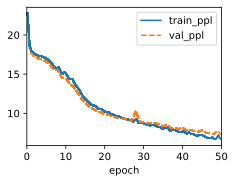

In [10]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(input_size=len(data.vocab), hidden_size=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

Always remember the the num_inputs = vocab_size and the `dimensions` of the matrices are (sequence_length, batch_size, vocab_size) and output matrix dimensions are (sequence_length, batch_size, vocab_size)

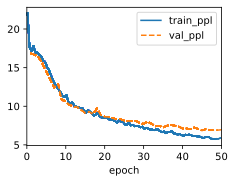

In [11]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens) # vocab_size, num_hidden

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [12]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a mon the time trav'